In [293]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [294]:
df = pd.read_csv('data.csv')

In [295]:
df.shape

(9529, 19)

In [296]:
df.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


##  Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [297]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median


In [298]:
# Completeness
df.isnull().sum()

Id                       0
team                     0
name                     0
position                 0
age                      0
appearance               0
goals                    0
assists                  0
goals conceded           0
clean sheets             0
minutes played           0
days_injured             0
games_injured            0
award                    0
current_value            0
highest_value            0
position_encoded         0
position_grouped         0
minutes_played_median    0
dtype: int64

In [299]:
# Accurecy types
df.dtypes

Id                         int64
team                      object
name                      object
position                  object
age                      float64
appearance                 int64
goals                    float64
assists                  float64
goals conceded           float64
clean sheets             float64
minutes played             int64
days_injured               int64
games_injured              int64
award                      int64
current_value              int64
highest_value              int64
position_encoded           int64
position_grouped          object
minutes_played_median    float64
dtype: object

In [300]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = [ 'team']
numeric_features = [ 'position_grouped', 'position_encoded','highest_value','current_value','award','games_injured','days_injured','minutes played','clean sheets','goals conceded','assists','goals','appearance','age']

In [301]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


In [302]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


In [303]:
for i in numeric_features:
    print (df[i].value_counts())

position_grouped
Defender Centre-Back          1683
Goalkeeper                    1172
midfield-CentralMidfield      1046
Attack Centre-Forward         1011
midfield-DefensiveMidfield     828
Defender Right-Back            808
Defender Left-Back             753
midfield-AttackingMidfield     645
Attack-RightWinger             613
Attack-LeftWinger              591
Other                          379
Name: count, dtype: int64
position_encoded
2    3277
3    2766
4    2314
1    1172
Name: count, dtype: int64
highest_value
1000000     440
1500000     393
2000000     380
50000       334
3000000     325
           ... 
3100000       1
90000000      1
80000000      1
37000000      1
625000        1
Name: count, Length: 141, dtype: int64
current_value
1000000     429
300000      425
500000      404
50000       391
1500000     383
           ... 
4400000       1
1750000       1
925000        1
21000000      1
3100000       1
Name: count, Length: 103, dtype: int64
award
0     4461
1     2049
2  

#### 2. Feature engineering

1. Feature scaling

2. Aggregation

3. One hot coding

In [304]:
df.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


In [305]:
categorical_features

['team']

In [306]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [307]:
df.shape

(9529, 392)

In [308]:
# Calculate the 35th and 75th percentiles of the price
p25 = df['current_value'].quantile(0.25)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p25:
        return 'Average Player'
    elif current_value < p75:
        return 'Good Player'
    else:
        return 'Professional Player'

# Apply the function to create a new column
df['player_leval_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_leval_category'].value_counts())

player_leval_category
Good Player            4710
Professional Player    2443
Average Player         2376
Name: count, dtype: int64


In [309]:
p25,p75

(300000.0, 2500000.0)

In [310]:
encoder = LabelEncoder()
df['player_leval_category_encoded'] = encoder.fit_transform(df['player_leval_category']) 

#### 3. Feature selection

In [311]:
df = df[['award', 'goals', 'position']]

In [312]:
df = pd.get_dummies(df, columns=['position'])

In [313]:
df 

,award,goals,position_Attack,position_Attack Centre-Forward,position_Attack-LeftWinger,position_Attack-RightWinger,position_Attack-SecondStriker,position_Defender,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,1,0.000000,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,4,0.000000,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1,0.037799,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,10,0.000000,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,0,0.000000,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9524,0,0.175953,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
9525,0,0.372671,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9526,0,0.375000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9527,0,0.312139,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [314]:
df.shape

(9529, 18)

### 4. Prepare train and test data

In [315]:
# Prepare data
X = df


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [316]:
X.shape

(9529, 18)

## Buliding the Model


In [317]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 15 #10 

In [318]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [319]:
distances[:,min_samples-1]

array([0.        , 0.        , 0.0144858 , ..., 0.05445093, 0.03718289,
       0.        ])

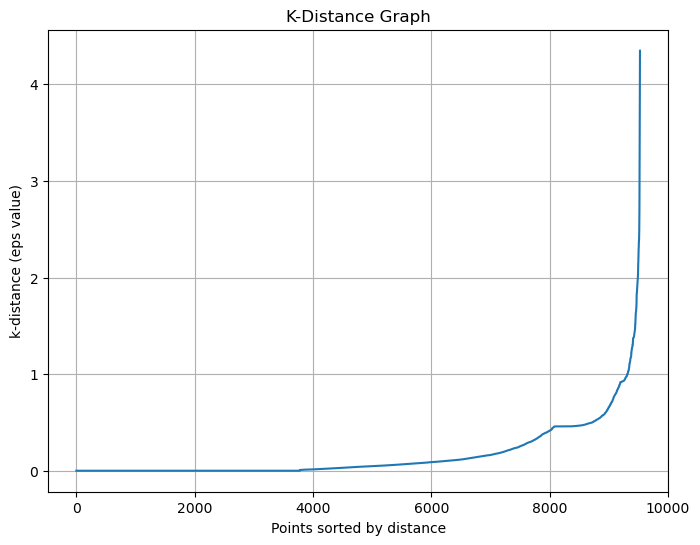

In [320]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [321]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = .8 #2  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

### Train the Model

In [322]:
clusters = dbscan.fit_predict(X_scaled)


In [323]:
pd.Series(clusters).value_counts()

 1     1680
 0     1172
 5     1038
 8      992
 4      819
 3      794
 2      747
 9      625
 7      598
 6      566
-1      179
 11      81
 10      77
 14      65
 16      39
 13      32
 15      16
 12       9
Name: count, dtype: int64

### Evaluating the Model


In [324]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.023645155219244405

In [325]:
X.head(2)

,award,goals,position_Attack,position_Attack Centre-Forward,position_Attack-LeftWinger,position_Attack-RightWinger,position_Attack-SecondStriker,position_Defender,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,1,0.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,4,0.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


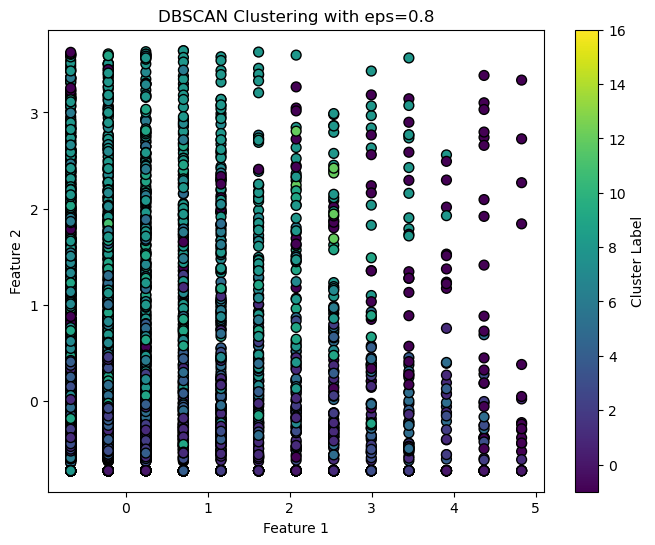

In [326]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [327]:
X['dbscan'] = clusters


In [328]:
X['dbscan'].value_counts()

dbscan
 1     1680
 0     1172
 5     1038
 8      992
 4      819
 3      794
 2      747
 9      625
 7      598
 6      566
-1      179
 11      81
 10      77
 14      65
 16      39
 13      32
 15      16
 12       9
Name: count, dtype: int64

<Axes: xlabel='award', ylabel='goals'>

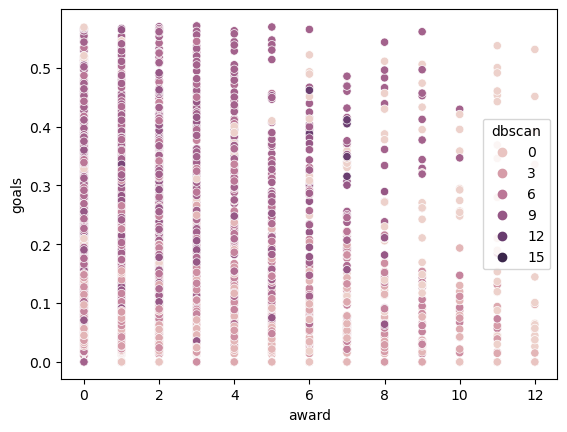

In [329]:
sns.scatterplot(data = X , x = 'award', y = 'goals', hue = 'dbscan')
